# Import modules.

In [208]:
%%capture
%load_ext autoreload
%autoreload 2


import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import holoviews as hv
import csv
import math

from scipy.stats import zscore
from dask.distributed import Client, LocalCluster
from holoviews.operation.datashader import datashade, regrid
from holoviews.util import Dynamic
from IPython.core.display import display

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
minian_path = "."

# Specify data location.

In [209]:
%%capture
sys.path.insert(0, minian_path)
from minian.utilities import (
    open_minian,
    match_information,
    match_path,
    TaskAnnotation
)

In [210]:
# Set up Initial Basic Parameters#

dpath = "/N/project/Cortical_Calcium_Image/Miniscope data/03.2023_Eighth_group/AA050_D8/2023_03_14/10_33_11/Miniscope_2/S4"
mouseID, day, session = match_information(dpath)
mouse_path, video_path = match_path(dpath)
timeStamp = os.path.join(video_path,"timeStamps.csv")
minian_ds_path = os.path.join(dpath, "minian")
output_dpath = "/N/project/Cortical_Calcium_Image/analysis"
output_path = os.path.join(output_dpath, mouseID,day,session)
n_workers = int(os.getenv("MINIAN_NWORKERS", 4))
behavior_data=pd.read_csv(os.path.join(mouse_path, mouseID+"_"+day+"_"+"behavior_ms.csv"),sep=',')

if(os.path.exists(output_path) == False):
    os.makedirs(output_path)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
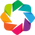

In [211]:
dpath = os.path.abspath(dpath)
hv.notebook_extension("bokeh", width=75)

# Load data

In [212]:
cluster = LocalCluster(
    n_workers=n_workers,
    memory_limit="5GB",
    resources={"MEM": 1},
    threads_per_worker=2,
    dashboard_address=":8787",
)
annt_plugin = TaskAnnotation()
cluster.scheduler.add_plugin(annt_plugin)
client = Client(cluster)

## Data structure of Minian outputs
Here is the output of Minian. It is an xarray Dataset that contains coordinate labels for different aspects of the data. The way you typically reference the data is the same as you would a Python dictionary. That is, using data['key']. For example, data['A']. See more here: https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html#xarray.Dataset. 

The most common variables you will be accessing are A, S, and sometimes C. 
data['A'] contains the spatial footprints of the detected neurons. 
data['S'] contains the deconvolved spikes.
data['C'] contains the modeled calcium traces. 

Each of these are arranged such that their first dimension is unit_id. So for example, in order to access the first neuron's spatial footprint you would call data['A'].sel(unit_id=0). To access the second, data['A'].sel(unit_id=1), etc.

In [213]:
# print(minian_ds_path)
data = open_minian(minian_ds_path)
data

<xarray.Dataset>
Dimensions:      (frame: 27229, height: 608, shift_dim: 2, unit_id: 11, width: 608)
Coordinates:
    animal       <U11 'Miniscope_2'
  * height       (height) int64 0 1 2 3 4 5 6 7 ... 601 602 603 604 605 606 607
    session      <U2 'S4'
  * unit_id      (unit_id) int64 20 22 24 26 30 36 42 45 65 66 74
    unit_labels  (unit_id) int64 dask.array<chunksize=(11,), meta=np.ndarray>
  * width        (width) int64 0 1 2 3 4 5 6 7 ... 601 602 603 604 605 606 607
  * frame        (frame) int64 0 1 2 3 4 5 ... 27224 27225 27226 27227 27228
  * shift_dim    (shift_dim) <U6 'height' 'width'
Data variables:
    A            (unit_id, height, width) float64 dask.array<chunksize=(1, 608, 608), meta=np.ndarray>
    f            (frame) float64 dask.array<chunksize=(50,), meta=np.ndarray>
    max_proj     (height, width) float64 dask.array<chunksize=(608, 608), meta=np.ndarray>
    b0           (unit_id, frame) float64 dask.array<chunksize=(1, 27229), meta=np.ndarray>
    c0           (unit_id, frame) float64 dask.array<chunksize=(1, 27229), meta=np.ndarray>
    S            (unit_id, frame) float64 dask.array<chunksize=(1, 27229), meta=np.ndarray>
    C            (unit_id, frame) float64 dask.array<chunksize=(1, 27229), meta=np.ndarray>
    motion       (frame, shift_dim) float64 dask.array<chunksize=(50, 2), meta=np.ndarray>
    b            (height, width) float64 dask.array<chunksize=(608, 608), meta=np.ndarray>

In [214]:
data['C'].sel(unit_id=data['unit_id'])

<xarray.DataArray 'C' (unit_id: 11, frame: 27229)>
dask.array<from-zarr, shape=(11, 27229), dtype=float64, chunksize=(1, 27229), chunktype=numpy.ndarray>
Coordinates:
    animal       <U11 'Miniscope_2'
    session      <U2 'S4'
  * unit_id      (unit_id) int64 20 22 24 26 30 36 42 45 65 66 74
    unit_labels  (unit_id) int64 dask.array<chunksize=(11,), meta=np.ndarray>
  * frame        (frame) int64 0 1 2 3 4 5 ... 27224 27225 27226 27227 27228

In [215]:
neuron_num = len(data['unit_id'])
neuron_num

11

# Store/open data in different formats

## Converting the data into other formats is relatively simple. See below for examples.

In [216]:
# Matlab-readable
data.to_netcdf(os.path.join(dpath, "minian_dataset.nc"))

In [217]:
# Pandas DataFrame
df = data['C'].to_pandas()
df

frame,0,1,2,3,4,5,6,7,8,9,...,27219,27220,27221,27222,27223,27224,27225,27226,27227,27228
unit_id,,,,,,,,,,,,,,,,,,,,,
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002198,0.002136,0.002077,0.002019,0.001963,0.001908,0.001855,0.001803,0.001753,0.001704
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.037625,0.036699,0.035796,0.034915,0.034056,0.033218,0.032401,0.031604,0.030826,0.030068
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.055843,0.054390,0.052974,0.051595,0.050252,0.048944,0.047670,0.046429,0.045221,0.044044
36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.024436,1.981818,1.940098,1.899256,1.859274,1.820134,1.781817,1.744307,1.707587,1.671640
42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000040,0.000039,0.000038,0.000037,0.000035,0.000034,0.000033,0.000032,0.000031,0.000030
65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.565060,6.435526,6.308548,6.184075,6.062058,5.942449,5.825199,5.710263,5.597595,5.487150


In [218]:
# Save C value 
df.to_csv(os.path.join(output_path, 'minian_'+mouseID+"_"+day+"_"+session+'_C.csv'))

In [219]:
df_S = data['S'].to_pandas()
df_S

frame,0,1,2,3,4,5,6,7,8,9,...,27219,27220,27221,27222,27223,27224,27225,27226,27227,27228
unit_id,,,,,,,,,,,,,,,,,,,,,
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [220]:
# Save S value
df_S.to_csv(os.path.join(output_path, 'minian_'+mouseID+"_"+day+"_"+session+'_S.csv'))

# Plotting data

## Calcium traces and spikes
Below are difference functions for plotting the modeled traces and spikes for individual neurons and groups of neurons. The features of these plots can be modified by the user.

In [221]:
# # Plot individual traces.
# def plot_trace(data, neuron):
#     fig, C_ax = plt.subplots(figsize=(12,6))
#     S_ax = C_ax.twinx()
#     C_ax.plot(data['C'].sel(unit_id=neuron), color='royalblue')
#     C_ax.set_ylabel("C [modeled activity, A.U.]", color='royalblue')
#     C_ax.set_xlabel('Frame #')
#     C_ax.set_title(f'Neuron #{neuron}')

#     S_ax.plot(data['S'].sel(unit_id=neuron), color='r', alpha=0.5)
#     S_ax.set_ylabel("S [modeled activity, A.U.]", color='r')

In [222]:
# neuron_number = 0
# plot_trace(data, neuron_number)

In [223]:
#behavior_data from lever press
behavior_data

,Frame Number,Time Stamp (ms),Buffer Index,RNFS,ALP,IALP
0,0,0,0,0,0,0
1,1,35,0,0,0,0
2,2,66,0,0,0,0
3,3,100,0,0,0,0
4,4,134,0,0,0,0
5,5,167,0,0,0,0
6,6,201,0,0,0,0
7,7,234,0,0,0,0
8,8,268,0,0,0,0
9,9,301,0,0,0,0


In [224]:
# Plot traces from multiple neurons
def plot_multiple_traces(data, neurons_to_plot, behavior_data, start_frame, session,shift_amount=0.4):
    shifts = [shift_amount * i for i in range(len(neurons_to_plot))]
    int:id_text_position
    if session == "S1":
        fifteen = behavior_data.loc[behavior_data['Time Stamp (ms)'] <= 900000]
        neuron_data=data.sel(frame=slice(0,len(fifteen)-1))
        id_text_position = -30
    else:
        fifteen = behavior_data.loc[behavior_data['Time Stamp (ms)'] >= 2700000]
        id_text_position = 2700000-30
#         print(len(fifteen))
#         print(len(data['C'].sel(unit_id=1)))
#         neuron_data=data.sel(frame=slice(len(data['C'].sel(unit_id=neurons_to_plot[0]))-len(fifteen),len(data['C'].sel(unit_id=neurons_to_plot[0])-1)))
        begin = len(data['C'].sel(unit_id=neurons_to_plot[0]))-len(fifteen) + data['frame'][0].values
        end = len(data['C'].sel(unit_id=neurons_to_plot[0])) + data['frame'][0].values - 1
#         print(begin)
#         print(end)
#         print(data['frame'])
#         print(data['frame'][0].values)
        neuron_data=data.sel(frame=slice(begin,end))
#         print(len(data['C'].sel(unit_id=neurons_to_plot[0])))
#         print(len(data['C'].sel(unit_id=neurons_to_plot[0]))-1)
#         print(len(fifteen))
#         print(len(neuron_data['C'].sel(unit_id=neurons_to_plot[0])))
    y=shifts[-1]+10
    fig, ax = plt.subplots(figsize=(30.4,y))
    for shift, neuron in zip(shifts, neurons_to_plot):
#         if session == "S1":
#             trace = data['C'].sel(frame=slice(0,len(fifteen))).sel(unit_id=neuron)
#         else:
#             trace = data['C'].sel(frame=slice(len(data['C'])-1-len(fifteen),len(data['C']-1))).sel(unit_id=neuron)
#         print(trace)
        trace = neuron_data['C'].sel(unit_id=neuron)
        trace /= np.max(trace)
#         ax.autoscale()
        ax.text(id_text_position,shift,neuron)
        ax.plot(fifteen['Time Stamp (ms)'],trace + shift)
#         ax.plot(behavior_data.loc[behavior_data['Frame Number']<len(trace)]['Time Stamp (ms)'],trace + shift)
#         start_frame,start_frame+len(trace)
        ax.vlines(fifteen.loc[fifteen['RNFS'] > 0]['Time Stamp (ms)'],0,y-8,color="green")
        ax.vlines(fifteen.loc[fifteen['IALP'] > 0]['Time Stamp (ms)'],0,y-9,color="blue")
        ax.vlines(fifteen.loc[fifteen['ALP'] > 0]['Time Stamp (ms)'],0,y-9,color="red",alpha=0.5)
#         if session == "S1":
#             ax.vlines(behavior_data.loc[(behavior_data['Frame Number']>=0) & (behavior_data['Frame Number']<(0+len(trace))) & (behavior_data['reinforcement']==1)]['Time Stamp (ms)'],0,y-8,color="green")
#             ax.vlines(behavior_data.loc[(behavior_data['Frame Number']>=0) & (behavior_data['Frame Number']<(0+len(trace))) & (behavior_data['IALP']==1)]['Time Stamp (ms)'],0,y-9,color="blue")
#             ax.vlines(behavior_data.loc[(behavior_data['Frame Number']>=0) & (behavior_data['Frame Number']<(0+len(trace))) & (behavior_data['ALP']==1)]['Time Stamp (ms)'],0,y-9,color="red",alpha=0.5)
#         else:
# #             ax.vlines(behavior_data.loc[(behavior_data['Frame Number']>=len(data['C'])-1-len(fifteen)) & (behavior_data['Frame Number']<(start_frame+len(trace))) & (behavior_data['reinforcement']==1)]['Time Stamp (ms)'],0,y-8,color="green")
# #             ax.vlines(behavior_data.loc[(behavior_data['Frame Number']>=len(data['C'])-1-len(fifteen)) & (behavior_data['Frame Number']<(start_frame+len(trace))) & (behavior_data['IALP']==1)]['Time Stamp (ms)'],0,y-9,color="blue")
# #             ax.vlines(behavior_data.loc[(behavior_data['Frame Number']>=len(data['C'])-1-len(fifteen)) & (behavior_data['Frame Number']<(start_frame+len(trace))) & (behavior_data['ALP']==1)]['Time Stamp (ms)'],0,y-9,color="red",alpha=0.5)
    ax.set_xlabel('Time Stamp (ms)')
    ax.set_ylabel('Neurons')
    ax.set_yticks([])
#     test=data['C'].sel(frame=slice(0,10)).sel(unit_id=0)
#     print(test)
    fig.savefig(os.path.join(output_path, mouseID+'_'+day+'_'+session+"_trace_ms.pdf"))

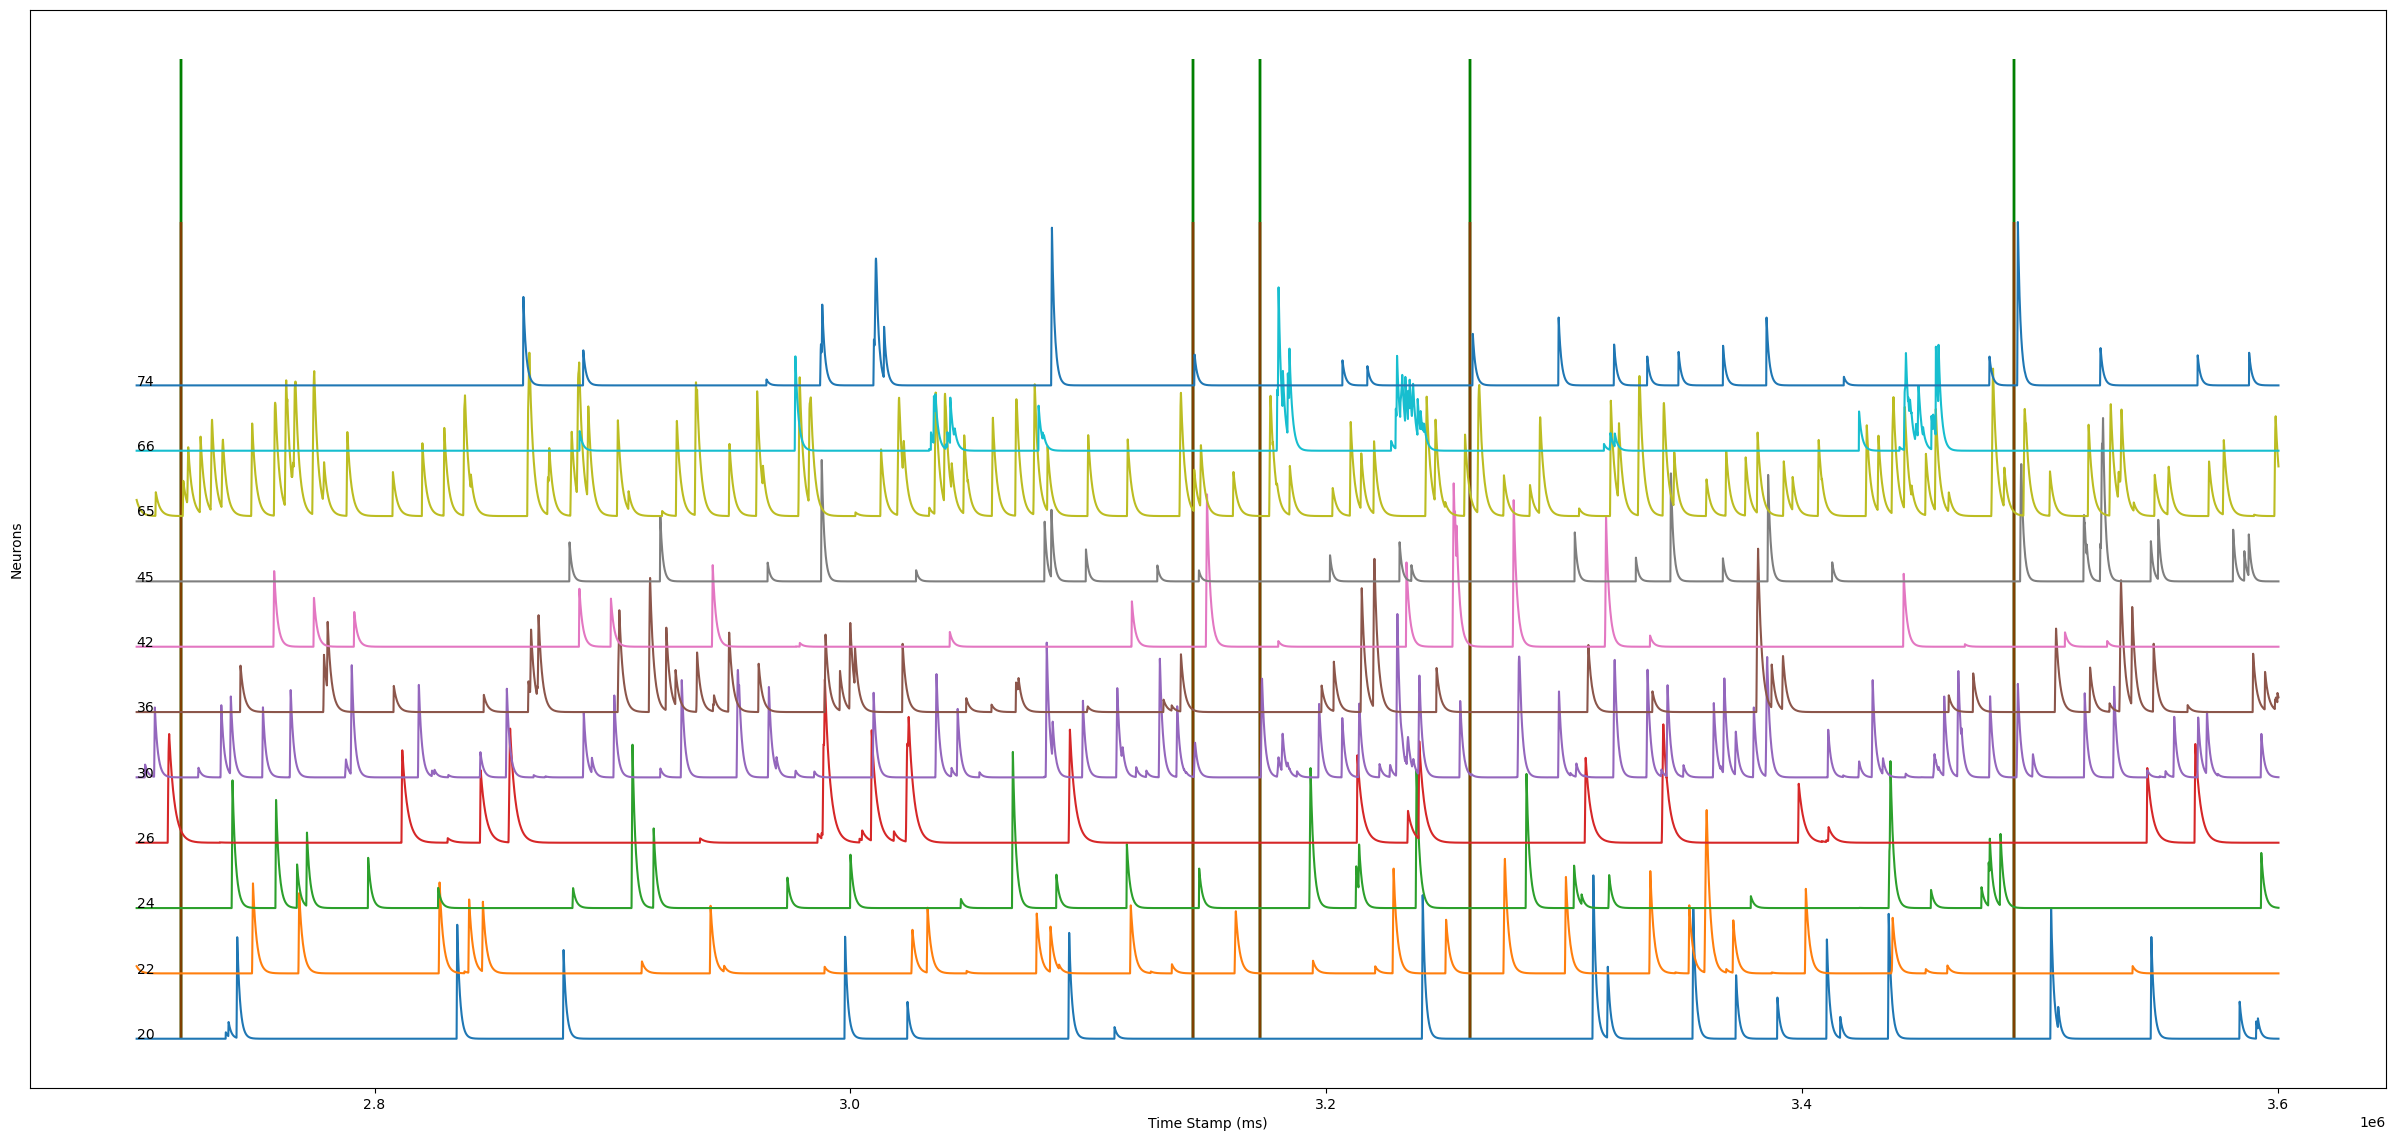

In [225]:
all_neurons=list(np.array(data['unit_id']))
plot_multiple_traces(data, all_neurons,behavior_data,0,session)

## Spatial footprints
Same for spatial footprints. Functions can be customizable by us or the user.

In [226]:
# Plot spatial footprints
def plot_footprints(data, neurons=None):
    if type(neurons) is int:
        neurons = [neurons]
    elif neurons is None:
        neurons = data['A']['unit_id']
    
    fov = np.zeros_like(data['A'].sel(unit_id=0))
    for neuron in neurons:
        fov += np.asarray(data['A'].sel(unit_id=neuron))
        
    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(fov, origin='lower')
    ax.axis('image')

In [227]:
# plot_footprints(data)

In [228]:
# plot_footprints(data, good_looking_neurons)

# Basic analysis
Here are some basic descriptive statistics of the detected neurons. 

## Mean amplitudes
It is a good idea to use the S matrix, rather than the C matrix. This is because the S matrix contains deconvolved spikes whereas the C matrix is the modeled calcium trace, which includes the decay portion of the calcium signal. 

In [229]:
# Histogram of mean amplitudes of all detected neurons. 
def histogram_mean_amplitude(data, nbins=50):
    mean_amplitudes = data['S'].mean(dim='frame')
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax.hist(mean_amplitudes, bins=nbins)
    ax.set_xlabel('Mean amplitudes [A.U.]')
    ax.set_ylabel('# of neurons')
    
    return np.asarray(mean_amplitudes)

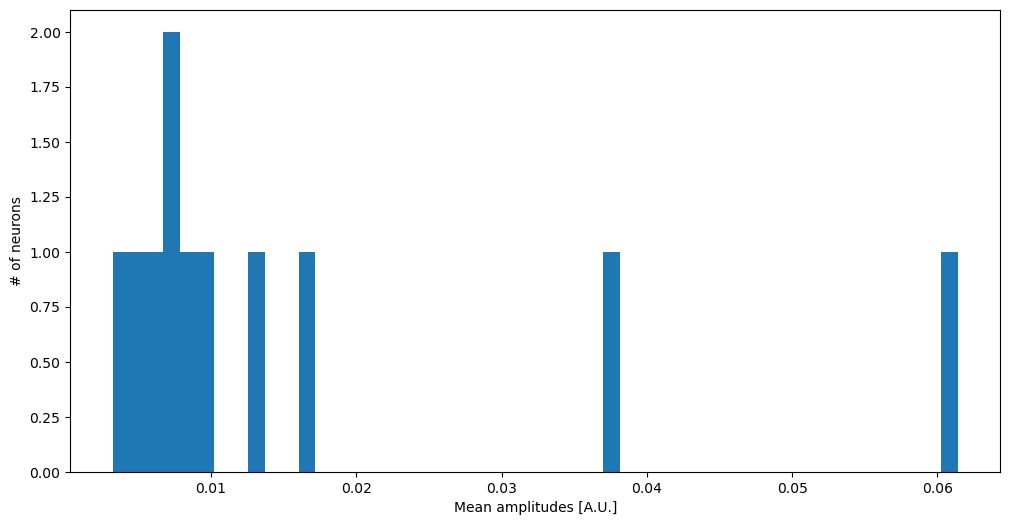

In [230]:
mean_amplitudes = histogram_mean_amplitude(data, nbins=50)

In [231]:
mean_amplitudes

array([0.00855441, 0.01669473, 0.00970062, 0.00739658, 0.06141955,
       0.01291031, 0.00563733, 0.00470985, 0.0379497 , 0.0075537 ,
       0.00321629])

## Event frequencies
It is even more important to use the S matrix here because the C matrix will include time bins where the calcium signal is decaying.

In [232]:
# Histogram of event frequencies of all detected neurons. 
def histogram_event_freq(data, nbins=50):
    event_freq = [np.sum(n > 0)/len(n) for n in np.asarray(data['S'])]
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax.hist(event_freq, bins=nbins)
    ax.set_xlabel('Event frequency [proportion of active frames]')
    ax.set_ylabel('# of neurons')
    
    return np.asarray(event_freq)

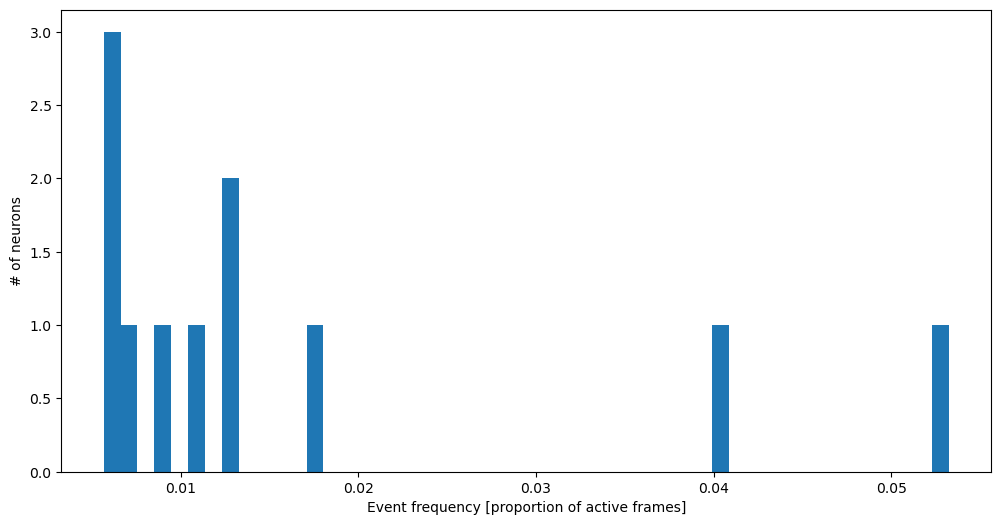

In [233]:
event_freq = histogram_event_freq(data)

In [234]:
event_freq

array([0.00631679, 0.01296412, 0.00907121, 0.01061368, 0.04080209,
       0.01784862, 0.00565573, 0.00738184, 0.05325205, 0.01267031,
       0.00580264])

# Digital Dataset(DDS)


## AUC of S per minute

### merge file

In [235]:
S_df=data['S'].to_pandas()
S_df=S_df.transpose()
S_df

unit_id,20,22,24,26,30,36,42,45,65,66,74
frame,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [236]:
# S_df[2] # unit_id: int

In [237]:
if session=="S1":
    new_pd=pd.merge(S_df,behavior_data,left_index=True,right_on='Frame Number',how='left')
else:
    temp_pd=behavior_data.tail(len(S_df))
    S_df.reset_index(drop=True, inplace = True)
    temp_pd.reset_index(drop=True, inplace=True)
    new_pd=pd.concat([S_df,temp_pd],axis=1)

In [238]:
new_pd

,20,22,24,26,30,36,42,45,65,66,74,Frame Number,Time Stamp (ms),Buffer Index,RNFS,ALP,IALP
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80000,2685982,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80001,2686015,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80002,2686049,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80003,2686083,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80004,2686116,0,0,0,0
5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80005,2686150,0,0,0,0
6,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80006,2686185,0,0,0,0
7,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80007,2686217,0,0,0,0
8,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80008,2686251,0,0,0,0
9,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80009,2686284,0,0,0,0


###  Check frame interval

In [239]:
new_pd.loc[new_pd['Time Stamp (ms)'].diff()>100]

,20,22,24,26,30,36,42,45,65,66,74,Frame Number,Time Stamp (ms),Buffer Index,RNFS,ALP,IALP


## AUC of S per min

In [240]:
new_pd['min']=new_pd['Time Stamp (ms)'].map(lambda x: math.floor(x/60000))
pd.set_option('display.min_rows',50)
res=new_pd.groupby('min').sum()
new_pd

,20,22,24,26,30,36,42,45,65,66,74,Frame Number,Time Stamp (ms),Buffer Index,RNFS,ALP,IALP,min
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80000,2685982,0,0,0,0,44
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80001,2686015,0,0,0,0,44
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80002,2686049,0,0,0,0,44
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80003,2686083,0,0,0,0,44
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80004,2686116,0,0,0,0,44
5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80005,2686150,0,0,0,0,44
6,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80006,2686185,0,0,0,0,44
7,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80007,2686217,0,0,0,0,44
8,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80008,2686251,0,0,0,0,44
9,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,80009,2686284,0,0,0,0,44


In [241]:
res.drop(columns=['Frame Number','Time Stamp (ms)','Buffer Index']).to_csv(os.path.join(output_path, mouseID+'_'+day+'_'+session+"_AUC_of_S_per_minute.csv"))

In [242]:
res

,20,22,24,26,30,36,42,45,65,66,74,Frame Number,Time Stamp (ms),Buffer Index,RNFS,ALP,IALP
min,,,,,,,,,,,,,,,,,
44,0.000000,11.136849,0.000000,0.000000,35.570130,0.000000,0.000000,8.946826,38.044330,0.000000,0.000000,33527153,1125666662,0,0,0,0
45,16.129136,21.896710,30.339789,14.185631,99.443578,5.497090,9.236822,0.000000,72.083334,0.000000,0.000000,145302757,4878505847,0,1,1,0
46,0.000000,19.191197,20.475094,11.115341,102.126452,18.470506,9.786160,0.000000,81.330899,0.000000,0.000000,148496126,4985719924,0,0,0,0
47,26.608387,56.565844,2.379630,23.728418,41.383640,25.022384,0.000000,0.000000,67.164897,0.000000,5.718394,151689495,5092933981,0,0,0,0
48,0.000000,2.737646,33.964332,0.495794,87.083254,53.339048,12.316714,7.881465,90.712011,2.379502,2.259101,154882864,5200147999,0,0,0,0
49,13.408946,18.741717,8.997914,23.215919,82.940848,43.571091,10.343196,11.355644,61.602663,12.520705,6.973317,158076233,5307362022,0,0,0,0
50,4.575960,26.951778,2.259870,34.172871,88.332668,15.365158,1.659625,0.808478,87.138262,20.685303,15.240107,161360742,5417636405,0,0,0,0
51,15.882618,41.328125,32.179482,13.983322,117.327914,6.649140,5.260068,12.225520,59.453501,6.658811,11.066959,164464758,5521851841,0,0,0,0
52,0.000000,18.333961,4.700245,0.000000,120.292952,9.043051,19.969342,1.970049,51.451909,23.967098,2.025865,167658127,5629065709,0,2,2,0


## Calculate z-score

In [243]:
# Contains left and right ends
def calculate_window(analyzed_zscore_df, action , start, end):
    output_df = analyzed_zscore_df
    for i in range(start,end + 1):
        # only line 2 so the mean is the same to line 2.
        series_positive = analyzed_zscore_df[analyzed_zscore_df[action].shift(i) > 0].mean()
        series_positive.name = action+"_positive_W"+str(i)
        series_negative = analyzed_zscore_df[analyzed_zscore_df[action].shift(i) == 0].mean()
        series_negative.name = action+"_negative_W"+str(i)
        output_df = output_df.append(series_positive)
        output_df = output_df.append(series_negative)
    return output_df

In [244]:
def calculate_zscore (session, input_df):
    neuron_ids = input_df.columns.values.tolist()
    neuron_ids = list(filter(lambda x:type(x) == int,neuron_ids))
    if session == "S1":
        analyzed_df = input_df.loc[0:14,:]
    elif session == "S4":
        analyzed_df = input_df.loc[45:59,:]
    neuron_value = analyzed_df.loc[:,neuron_ids]
    behavior_value = analyzed_df.loc[:,["RNFS","ALP","IALP"]]
    zscore_df = zscore(neuron_value,axis = 0)
    sum_zscore_df = pd.merge(zscore_df,behavior_value,left_index=True,right_index=True)
    print(sum_zscore_df)
    output_zscore_df = calculate_window(sum_zscore_df, "ALP", -1, 1)
    output_zscore_df = calculate_window(output_zscore_df, "IALP", -1, 1)
    output_zscore_df = calculate_window(output_zscore_df, "RNFS", -1, 3)
    return output_zscore_df

### AUC zscore

In [245]:
AUC_zscore = calculate_zscore(session, res)

           20        22        24        26        30        36        42  \
min                                                                         
45   0.045474 -0.283672  0.880986  0.067582 -0.265547 -1.071849 -0.087547   
46  -1.175738 -0.383783  0.198325 -0.205847 -0.191933 -0.296673 -0.039282   
47   0.838907  0.999185 -1.053924  0.917429 -1.858615  0.094809 -0.899098   
48  -1.175738 -0.992611  1.131813 -1.151586 -0.604693  1.786760  0.183054   
49  -0.160484 -0.400415 -0.595923  0.871787 -0.718354  1.203114  0.009660   
50  -0.829271 -0.096620 -1.062211  1.847575 -0.570412 -0.482221 -0.753283   
51   0.026809  0.435346  1.008297  0.049565  0.225170 -1.003012 -0.436946   
52  -1.175738 -0.415503 -0.893332 -1.195740  0.306525 -0.859974  0.855418   
53  -1.175738  0.026528  2.125441  1.078207  2.579219  1.314012 -0.029973   
54   0.292018  0.500734 -0.023250 -1.195740 -0.200530 -1.090273  3.183217   
55   2.561837  3.076903 -0.491475  1.072436  0.332503 -0.741170  0.632930   

In [246]:
AUC_zscore.to_csv(os.path.join(output_path, mouseID+'_'+day+'_'+session+"_AUC_zscore.csv"))

In [247]:
zscore_summary_index_list = list(filter(lambda x: type(x) != int,AUC_zscore.index.tolist()))
AUC_zscore_summary = AUC_zscore.loc[zscore_summary_index_list,:]
AUC_zscore_summary

,20,22,24,26,30,36,42,45,65,66,74,RNFS,ALP,IALP
min,,,,,,,,,,,,,,
ALP_positive_W-1,-0.353197,-0.012104,1.459948,-0.022656,1.260824,-0.234218,-0.194708,-0.193952,-0.334040,1.488073,-0.133587,0.000000,0.000000,0.0
ALP_negative_W-1,0.055627,0.102748,-0.329353,-0.052196,-0.264498,0.064565,0.134838,-0.030598,0.233661,-0.349243,0.074137,0.454545,0.454545,0.0
ALP_positive_W0,-0.119945,-0.307942,-0.156854,-0.879910,-0.125308,-0.388651,0.812085,0.178596,0.083282,-0.326373,0.018341,1.250000,1.250000,0.0
ALP_negative_W0,0.043616,0.111979,0.057038,0.319967,0.045567,0.141328,-0.295304,-0.064944,-0.030284,0.118681,-0.006669,0.000000,0.000000,0.0
ALP_positive_W1,0.164512,0.406434,0.268832,0.646729,0.461699,0.067153,-0.083856,0.129914,-0.569066,0.236196,-0.548844,0.000000,0.000000,0.0
ALP_negative_W1,-0.070352,-0.134206,-0.195631,-0.265450,-0.158125,0.080324,0.042297,0.030600,0.193684,-0.032224,0.347524,0.400000,0.400000,0.0
IALP_positive_W-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IALP_negative_W-1,-0.010469,0.015056,0.064981,0.000597,0.068914,-0.017491,0.018653,0.000951,-0.030822,0.058367,-0.029831,0.335227,0.335227,0.0
IALP_positive_W0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [248]:
def calculate_mean(Series,ngtv_near=0.1,ngtv_far=0,pstv_near=0.1,pstv_far=0):
    series=Series.sort_values()
    # total number
    total = len(Series)
    
    # ngtv number
    ngtv_series= series[series<0]
    ngtv_number = len(ngtv_series)
    
    # pstv number
    pstv_series = series[series>0]
    pstv_number = len(pstv_series)
    
    # number of ngtv be analyzed
    ngtv_series_analyzed = ngtv_series[round(len(ngtv_series)*ngtv_far):round(len(ngtv_series)*(1-ngtv_near))]
    ngtv_analyzed_number = len(ngtv_series_analyzed)
    
    # analyzed ngtv neuron ID
    ngtv_neurons_list = ngtv_series_analyzed.index.to_list()
    ngtv_neurons=','.join([str(i) for i in ngtv_neurons_list])
#     print(ngtv_neurons)
    
    # analyzed ngtv neuron zscore
    ngtv_neurons_zscore_list = ngtv_series_analyzed.values.tolist()
    ngtv_neurons_zscore = ','.join([str(i) for i in ngtv_neurons_zscore_list])
    print(ngtv_neurons_zscore)
    print(type(ngtv_neurons_zscore))
    
    # ngtv mean
    ngtv_mean = ngtv_series_analyzed.mean()
    
    # number of pstv be analyzed
    pstv_series_analyzed = pstv_series[round(len(pstv_series)*pstv_near):round(len(pstv_series)*(1-pstv_far))]
    pstv_analyzed_number = len(pstv_series_analyzed)
    
    # analyzed pstv neuron ID
    pstv_neurons_list = pstv_series_analyzed.index.to_list()
    pstv_neurons=','.join([str(i) for i in pstv_neurons_list])
#     print(pstv_neurons)
    
    # analyzed pstv neuron zscore
    pstv_neurons_zscore_list = pstv_series_analyzed.values.tolist()
    pstv_neurons_zscore = ','.join([str(i) for i in pstv_neurons_zscore_list])
#     print(pstv_neurons_zscore)
#     print(type(pstv_neurons_zscore))
    
    # pstv mean
    pstv_mean = pstv_series_analyzed.mean()
    
    out = pd.Series([total,ngtv_number,ngtv_near,ngtv_far,ngtv_analyzed_number,ngtv_neurons,ngtv_neurons_zscore,ngtv_mean,pstv_number,pstv_near,pstv_far,pstv_analyzed_number,pstv_neurons,pstv_neurons_zscore,pstv_mean],index=["total neuron","ngtv neuron","near (%) in the ngtv side", "far (%) in the ngtv side","ngtv neuron to be analyzed","analyzed ngtv neuron ID","analyzed ngtv zscore","negative mean","pstv neuron","near (%) in the pstv side","far (%) in the pstv side","pstv neuron to be analyzed","analyzed pstv neuron ID","analyzed pstv zscore","positive mean"])
#     out = pd.concat([Series,out])
    return out

In [249]:
AUC_zscore_calculate_version1 = AUC_zscore_summary.iloc[:,:-3].apply(calculate_mean,ngtv_near=0.1,pstv_near=0.1,axis=1)
AUC_zscore_summary_version1 = pd.concat([AUC_zscore_summary,AUC_zscore_calculate_version1],axis=1)
AUC_zscore_summary_version1.to_csv(os.path.join(output_path, mouseID+'_'+day+'_'+session+"_AUC_zscore_summary_version1.csv"))

-0.3531967823878752,-0.3340402348033589,-0.2342183462455394,-0.1947080632120128,-0.1939517189369401,-0.13358713574491696,-0.02265603563748808
<class 'str'>
-0.34924256779845886,-0.32935269037506393,-0.2644982386835445,-0.052195590581662676
<class 'str'>
-0.8799095101390955,-0.3886507481961192,-0.3263726154877771,-0.3079423238598836,-0.1568538309279473,-0.125308260200705
<class 'str'>
-0.29530364528424274,-0.06494389390132772,-0.030284482681837144,-0.006669400627636753
<class 'str'>
-0.5690657213583145,-0.5488438482347109,-0.08385572161025434
<class 'str'>
-0.2654497807564139,-0.1956313216011871,-0.15812496000689213,-0.13420636082882348,-0.07035230853882614
<class 'str'>

<class 'str'>
-0.030822363295833037,-0.029831105833570647,-0.017491208650008576,-0.01046928571848923
<class 'str'>

<class 'str'>
-0.020131567152294305,-0.013320858233743368,-0.012833348586860535,-0.012072137117995882
<class 'str'>

<class 'str'>
-0.03810911192233216,-0.016260602826144395,-0.016054845743960166
<class '

In [250]:
AUC_zscore_calculate_version2 = AUC_zscore_summary.iloc[:,:-3].apply(calculate_mean,ngtv_near=0.2,pstv_near=0.2,axis=1)
AUC_zscore_summary_version2 =pd.concat([AUC_zscore_summary, AUC_zscore_calculate_version2],axis=1)
AUC_zscore_summary_version2.to_csv(os.path.join(output_path, mouseID+'_'+day+'_'+session+"_AUC_zscore_summary_version2.csv"))

-0.3531967823878752,-0.3340402348033589,-0.2342183462455394,-0.1947080632120128,-0.1939517189369401,-0.13358713574491696
<class 'str'>
-0.34924256779845886,-0.32935269037506393,-0.2644982386835445,-0.052195590581662676
<class 'str'>
-0.8799095101390955,-0.3886507481961192,-0.3263726154877771,-0.3079423238598836,-0.1568538309279473,-0.125308260200705
<class 'str'>
-0.29530364528424274,-0.06494389390132772,-0.030284482681837144
<class 'str'>
-0.5690657213583145,-0.5488438482347109
<class 'str'>
-0.2654497807564139,-0.1956313216011871,-0.15812496000689213,-0.13420636082882348,-0.07035230853882614
<class 'str'>

<class 'str'>
-0.030822363295833037,-0.029831105833570647,-0.017491208650008576
<class 'str'>

<class 'str'>
-0.020131567152294305,-0.013320858233743368,-0.012833348586860535,-0.012072137117995882
<class 'str'>

<class 'str'>
-0.03810911192233216,-0.016260602826144395
<class 'str'>
-0.27859430250332723,-0.1987745753222577,-0.1681758291674206,-0.13419266805654337,-0.1213082591069148

## AUC of S per Event

In [251]:
column_name = new_pd.columns.values  #get column label
print(column_name)
print(column_name[:-7])

[20 22 24 26 30 36 42 45 65 66 74 'Frame Number' 'Time Stamp (ms)'
 'Buffer Index' 'RNFS' 'ALP' 'IALP' 'min']
[20 22 24 26 30 36 42 45 65 66 74]


In [252]:
mark = np.zeros(column_name.size-7)
flag = np.zeros(column_name.size-7)

# for i in column_name[:-7]:
#     print(str(i)+": "+str(np.argwhere(new_pd.columns.values==i)[0][0]))


for i in column_name[:-7]:
    new_pd.insert(int(np.argwhere(new_pd.columns.values==i)[0][0]) + 1,str(i)+'_mark',0)   

for index,row in new_pd.iterrows():
    for i in range(column_name.size-7):
        if row[column_name[i]] == 0 and flag[i] != 0:
            flag[i]=0
        elif row[column_name[i]] == 0 and flag[i] == 0:
            continue
        elif row[column_name[i]] != 0 and flag[i] != 0:   
            new_pd.loc[index,str(column_name[i])+'_mark'] = mark[i]
        else:
            flag[i]=1
            mark[i]=mark[i]+1
            new_pd.loc[index,str(column_name[i])+'_mark'] = mark[i]



In [253]:
new_pd

,20,20_mark,22,22_mark,24,24_mark,26,26_mark,30,30_mark,...,66_mark,74,74_mark,Frame Number,Time Stamp (ms),Buffer Index,RNFS,ALP,IALP,min
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80000,2685982,0,0,0,0,44
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80001,2686015,0,0,0,0,44
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80002,2686049,0,0,0,0,44
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80003,2686083,0,0,0,0,44
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80004,2686116,0,0,0,0,44
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80005,2686150,0,0,0,0,44
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80006,2686185,0,0,0,0,44
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80007,2686217,0,0,0,0,44
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80008,2686251,0,0,0,0,44
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80009,2686284,0,0,0,0,44


In [254]:
# print(column_name)
print(new_pd.columns.values)

[20 '20_mark' 22 '22_mark' 24 '24_mark' 26 '26_mark' 30 '30_mark' 36
 '36_mark' 42 '42_mark' 45 '45_mark' 65 '65_mark' 66 '66_mark' 74
 '74_mark' 'Frame Number' 'Time Stamp (ms)' 'Buffer Index' 'RNFS' 'ALP'
 'IALP' 'min']


In [255]:
for i in range(column_name.size-8,-1,-1):
    SUM = pd.DataFrame()
    SUM[str(column_name[i])+'_sum'] = new_pd[column_name[i]].groupby(new_pd[str(column_name[i])+'_mark']).sum()
    temp = pd.merge(new_pd[str(column_name[i])+'_mark'],SUM,how='left',left_on=str(column_name[i])+'_mark',right_index=True)
#     print(temp)
#     print(type(new_pd[column_name[i]].groupby(new_pd[str(column_name[i])+'_mark']).sum()))
    new_pd.insert(int(np.argwhere(new_pd.columns.values==str(column_name[i])+'_mark')[0][0])+1,str(column_name[i])+'_sum',0)
    new_pd.update(temp)

new_pd.insert(int(np.argwhere(new_pd.columns.values == 'Time Stamp (ms)')[0][0])+1,'Time Interval (ms)',new_pd['Time Stamp (ms)'].diff())
new_pd.to_csv(os.path.join(output_path, mouseID+'_'+day+'_'+session+"_AUC_of_S_per_event.csv"))

In [256]:
# print(new_pd[2].groupby(new_pd['2_mark']).count())

## Frequency

In [257]:
behavior_df=new_pd.loc[:,["min","RNFS","ALP","IALP"]]
behavior_df2=behavior_df.groupby(behavior_df["min"]).sum()
behavior_df2

,RNFS,ALP,IALP
min,,,
44,0,0,0
45,1,1,0
46,0,0,0
47,0,0,0
48,0,0,0
49,0,0,0
50,0,0,0
51,0,0,0
52,2,2,0


In [258]:
df_min=new_pd['min']
frequency_df=new_pd.diff()
col=[]
for i in column_name[:-7]:
    col.append(str(i)+'_mark')
frequency_df=frequency_df[col]
frequency_df[frequency_df<0]=0
frequency_df2=frequency_df[frequency_df>0]
frequency_df2['min']=df_min
frequency_df2 = frequency_df2.groupby('min').count()
frequency_df2.columns=frequency_df2.columns.str.rstrip('_mark').astype('int64')
frequency_df3=pd.merge(frequency_df2,behavior_df2,left_index=True, right_on="min")
frequency_df3.to_csv(os.path.join(output_path, mouseID+'_'+day+'_'+session+"_Number_of_S_events_per_min.csv"))
frequency_df3.columns.values

array([20, 22, 24, 26, 30, 36, 42, 45, 65, 66, 74, 'RNFS', 'ALP', 'IALP'],
      dtype=object)

In [259]:
Freq_zscore = calculate_zscore(session, frequency_df3)
Freq_zscore.to_csv(os.path.join(output_path, mouseID+'_'+day+'_'+session+"_Freq_zscore.csv"))

           20        22        24        26        30        36        42  \
min                                                                         
45   1.032094 -1.038582 -0.140488  0.086387 -0.506014 -1.568929 -0.490511   
46  -1.179536 -1.038582  0.561951 -0.561514 -1.166033 -0.392232  0.429198   
47   0.294884  0.908759 -0.842927  0.734288  0.154004  0.196116 -1.410220   
48  -1.179536 -1.038582  0.561951 -0.561514 -0.836023  0.784465  0.429198   
49  -0.442326  0.259645 -0.140488  0.734288 -0.836023  1.372813  1.348907   
50  -0.442326  0.259645 -0.842927  2.030091 -0.176005  0.196116 -0.490511   
51   0.294884  0.908759  0.561951 -0.561514 -0.176005  0.196116 -0.490511   
52  -1.179536  0.259645 -0.842927 -1.209416  0.154004 -0.392232  0.429198   
53  -1.179536  0.259645  1.264391  0.734288  2.794078  0.784465 -0.490511   
54  -0.442326 -0.389468 -0.842927 -1.209416 -0.506014 -1.568929  2.268616   
55   1.032094  2.206986  0.561951  0.734288  0.484014 -0.980581  0.429198   

In [260]:
zscore_summary_index_list = list(filter(lambda x: type(x) != int,Freq_zscore.index.tolist()))
Freq_zscore_summary = Freq_zscore.loc[zscore_summary_index_list,:]

In [261]:
Freq_zscore_calculate_version1 = Freq_zscore_summary.iloc[:,:-3].apply(calculate_mean,ngtv_near=0.1,pstv_near=0.1,axis=1)
Freq_zscore_summary_version1 = pd.concat([Freq_zscore_summary, Freq_zscore_calculate_version1],axis=1)
Freq_zscore_summary_version1.to_csv(os.path.join(output_path, mouseID+'_'+day+'_'+session+"_Freq_zscore_summary_version1.csv"))

-0.5751081237516718,-0.4423258684646914,-0.345547370232544,-0.2800560168056021
<class 'str'>
-0.3860108084539572,-0.3342825889286703,-0.33206224228805525,-0.2025232876417048,-0.1782873955801672
<class 'str'>
-0.885465136220894,-0.686406472983644,-0.6673173907519571,-0.5517464610700924,-0.5170933797490369,-0.5060141685950836,-0.3675735220573527,-0.23118224344005928
<class 'str'>
-0.2396817417986685,-0.1176357525855694
<class 'str'>
-0.4852474794154731,-0.26058421928111053,-0.06491134836118745
<class 'str'>
-0.17600492820698563,-0.14744195615489716,-0.1404878717372542,-0.10798355319767002,-0.1050828379272997
<class 'str'>

<class 'str'>
-0.03145122551766977,-0.028713808463925884,-0.020943459681093377,-0.01591227368213661
<class 'str'>

<class 'str'>
-0.032488558213151796,-0.026967197608417363,-0.02225120716896371,-0.012013174511711189
<class 'str'>

<class 'str'>
-0.07992024214305224,-0.03953868350792764,-0.0384323282517162
<class 'str'>
-0.42670190810552544,-0.28315557488838206,-0.17457

In [262]:
Freq_zscore_calculate_version2 = Freq_zscore_summary.iloc[:,:-3].apply(calculate_mean,ngtv_near=0.2,pstv_near=0.2,axis=1)
Freq_zscore_summary_version2 = pd.concat([Freq_zscore_summary,Freq_zscore_calculate_version2],axis=1)
Freq_zscore_summary_version2.to_csv(os.path.join(output_path, mouseID+'_'+day+'_'+session+"_Freq_zscore_summary_version2.csv"))

-0.5751081237516718,-0.4423258684646914,-0.345547370232544,-0.2800560168056021
<class 'str'>
-0.3860108084539572,-0.3342825889286703,-0.33206224228805525,-0.2025232876417048,-0.1782873955801672
<class 'str'>
-0.885465136220894,-0.686406472983644,-0.6673173907519571,-0.5517464610700924,-0.5170933797490369,-0.5060141685950836,-0.3675735220573527
<class 'str'>
-0.2396817417986685,-0.1176357525855694
<class 'str'>
-0.4852474794154731,-0.26058421928111053
<class 'str'>
-0.17600492820698563,-0.14744195615489716,-0.1404878717372542,-0.10798355319767002,-0.1050828379272997
<class 'str'>

<class 'str'>
-0.03145122551766977,-0.028713808463925884,-0.020943459681093377,-0.01591227368213661
<class 'str'>

<class 'str'>
-0.032488558213151796,-0.026967197608417363,-0.02225120716896371,-0.012013174511711189
<class 'str'>

<class 'str'>
-0.07992024214305224,-0.03953868350792764
<class 'str'>
-0.42670190810552544,-0.28315557488838206,-0.17457341100289983,-0.154083850155355
<class 'str'>
-0.3514477440699

## Amp

In [263]:
neuron_ids = res.columns.values.tolist()
neuron_ids = list(filter(lambda x:type(x) == int,neuron_ids))

In [264]:
if session =="S1":
    amp_df=res.loc[0:14,neuron_ids]/frequency_df2.loc[0:14,:]
elif session == "S4":
    amp_df=res.loc[45:59,neuron_ids]/frequency_df2.loc[45:59,:]
amp_df=amp_df.fillna(0)
amp_df=amp_df.replace(np.inf,0)
# amp_df
if session =="S1":
    amp_df=pd.merge(amp_df,res.loc[0:14,["RNFS","ALP","IALP"]],left_index=True,right_index=True)
elif session == "S4":
    amp_df=pd.merge(amp_df,res.loc[45:59,["RNFS","ALP","IALP"]],left_index=True,right_index=True)
amp_df.to_csv(os.path.join(output_path, mouseID+'_'+day+'_'+session+"_average_Amp_per_event.csv"))

In [265]:
Amp_zscore = calculate_zscore(session, amp_df)
Amp_zscore.to_csv(os.path.join(output_path, mouseID+'_'+day+'_'+session+"_Amp_zscore.csv"))

           20        22        24        26        30        36        42  \
min                                                                         
45  -0.407120  1.654093  1.616754  0.314817  0.197686 -0.219619  1.058594   
46  -1.242729  1.265873 -0.162331  1.190716  1.997568  0.007409 -0.051768   
47   0.825039  0.541276 -1.110069  0.492643 -2.093131  0.041394 -1.302553   
48  -1.242729 -1.095081  0.796283 -1.121674  0.367015  1.559699  0.271667   
49   0.841320 -0.591483 -0.658239  0.455444  0.200547  0.387660 -0.421232   
50  -0.531523 -0.198790 -1.135601  0.258585 -0.596994 -0.789403 -0.878314   
51  -0.008473 -0.005347  0.669442  1.815214  0.235300 -1.539230  0.042043   
52  -1.242729 -0.610986 -0.615325 -1.229633 -0.111209 -1.073965  1.249762   
53  -1.242729 -0.039607  0.958144  0.623680 -0.581688  1.015176  1.226101   
54   1.770188  1.604002  2.065179 -1.229633  0.277039 -0.325725  1.666742   
55   1.314690  1.207732 -0.870698  0.618977 -0.425775 -0.213223  0.926106   

In [266]:
zscore_summary_index_list = list(filter(lambda x: type(x) != int,Amp_zscore.index.tolist()))
Amp_zscore_summary = Amp_zscore.loc[zscore_summary_index_list,:]

In [267]:
Amp_zscore_calculate_version1 = Amp_zscore_summary.iloc[:,:-3].apply(calculate_mean,ngtv_near=0.1,pstv_near=0.1,axis=1)
Amp_zscore_summary_version1 = pd.concat([Amp_zscore_summary, Amp_zscore_calculate_version1],axis=1)
Amp_zscore_summary_version1.to_csv(os.path.join(output_path, mouseID+'_'+day+'_'+session+"_Amp_zscore_summary_version1.csv"))

-0.507304000109546,-0.35162890679639447,-0.2542718988502385,-0.20636463079376663
<class 'str'>
-0.20240628155335624,-0.09822749163673695,-0.07572190354037683
<class 'str'>
-0.8435202538587125,-0.35073937401680305,-0.1068375913451094,-0.0790804695741702
<class 'str'>
-0.3072877060857946,-0.26892537788134246,-0.1897209851263783,-0.14372647151642132,-0.12673913304950216
<class 'str'>
-0.691943416720599,-0.395094862800347,-0.3293397473874957,-0.32204197902531384,-0.06752446188592015,-0.050202223443053084,-0.03900603643206596
<class 'str'>
-0.3765397960425091,-0.2600179580448517,-0.18564811888608332,-0.13466561191334994
<class 'str'>

<class 'str'>
-0.019408977402005197,-0.018744817616681456,-0.013047519416397254,-0.012491892160119105
<class 'str'>

<class 'str'>
-0.016695964528148272,-0.005396737550101045,-0.004772115643514013,-0.0029619267409141457
<class 'str'>

<class 'str'>
-0.07527278490157416,-0.047708991219524315,-0.009416924620040597,-0.008240815119229616,-0.0065498235664738155,-0.

In [268]:
Amp_zscore_calculate_version2 = Amp_zscore_summary.iloc[:,:-3].apply(calculate_mean,ngtv_near=0.2,pstv_near=0.2,axis=1)
Amp_zscore_summary_version2 = pd.concat([Amp_zscore_summary,Amp_zscore_calculate_version2],axis=1)
Amp_zscore_summary_version2.to_csv(os.path.join(output_path, mouseID+'_'+day+'_'+session+"_Amp_zscore_summary_version2.csv"))

-0.507304000109546,-0.35162890679639447,-0.2542718988502385
<class 'str'>
-0.20240628155335624,-0.09822749163673695
<class 'str'>
-0.8435202538587125,-0.35073937401680305,-0.1068375913451094,-0.0790804695741702
<class 'str'>
-0.3072877060857946,-0.26892537788134246,-0.1897209851263783,-0.14372647151642132,-0.12673913304950216
<class 'str'>
-0.691943416720599,-0.395094862800347,-0.3293397473874957,-0.32204197902531384,-0.06752446188592015,-0.050202223443053084
<class 'str'>
-0.3765397960425091,-0.2600179580448517,-0.18564811888608332
<class 'str'>

<class 'str'>
-0.019408977402005197,-0.018744817616681456,-0.013047519416397254,-0.012491892160119105
<class 'str'>

<class 'str'>
-0.016695964528148272,-0.005396737550101045,-0.004772115643514013
<class 'str'>

<class 'str'>
-0.07527278490157416,-0.047708991219524315,-0.009416924620040597,-0.008240815119229616,-0.0065498235664738155,-0.003281346579975963
<class 'str'>
-0.30701733170667284,-0.20875902880550334,-0.1366499956528482,-0.095992377

In [269]:
# amp_zscore=zscore(amp_df,axis=0)
# amp_zscore_=pd.merge(amp_zscore,behavior_df3,left_index=True,right_on="min")
# amp_zscore_

In [270]:
# amp_ALP_Wm1_positive = amp_zscore_[amp_zscore_["ALP"].shift(-1)>0].mean() 
# amp_ALP_Wm1_positive.name="ALP_positive_w-1"
# amp_ALP_Wm1_negative = amp_zscore_[amp_zscore_["ALP"].shift(-1)==0].mean() 
# amp_ALP_Wm1_negative.name="ALP_negative_w-1"
# amp_ALP_positive = amp_zscore_[amp_zscore_["ALP"] > 0].mean()
# amp_ALP_positive.name = "ALP_positive_w0"
# amp_ALP_negative = amp_zscore_[amp_zscore_["ALP"] == 0].mean()
# amp_ALP_negative.name="ALP_negative_w0"
# amp_IALP_Wm1_positive = amp_zscore_[amp_zscore_["IALP"].shift(-1)>0].mean() 
# amp_IALP_Wm1_positive.name="IALP_positive_w-1"
# amp_IALP_Wm1_negative = amp_zscore_[amp_zscore_["IALP"].shift(-1)==0].mean() 
# amp_IALP_Wm1_negative.name="IALP_negative_w-1"
# amp_IALP_W0_positive = amp_zscore_[amp_zscore_["IALP"] > 0].mean() 
# amp_IALP_W0_positive.name="IALP_positive_w0"
# amp_IALP_W0_negative = amp_zscore_[amp_zscore_["IALP"] == 0].mean() 
# amp_IALP_W0_negative.name="IALP_negative_w0"
# amp_RNFS_positive = amp_zscore_[amp_zscore_["RNFS"]>0].mean()
# amp_RNFS_positive.name="RNFS_positive_w0"
# amp_RNFS_negative = amp_zscore_[amp_zscore_["RNFS"] == 0].mean()
# amp_RNFS_negative.name="RNFS_negative_w0"
# amp_RNFS_W1_positive = amp_zscore_[amp_zscore_["RNFS"].shift(1)>0].mean()
# amp_RNFS_W1_positive.name = "RNFS_positive_w1"
# amp_RNFS_W1_negative = amp_zscore_[amp_zscore_["RNFS"].shift(1) == 0].mean()
# amp_RNFS_W1_negative.name = "RNFS_negative_w1"
# amp_RNFS_W2_positive = amp_zscore_[amp_zscore_["RNFS"].shift(2)>0].mean()
# amp_RNFS_W2_positive.name = "RNFS_positive_w2"
# amp_RNFS_W2_negative = amp_zscore_[amp_zscore_["RNFS"].shift(2) == 0].mean()
# amp_RNFS_W2_negative.name = "RNFS_negative_w2"
# amp_RNFS_W3_positive = amp_zscore_[amp_zscore_["RNFS"].shift(3)>0].mean()
# amp_RNFS_W3_positive.name = "RNFS_positive_w3"
# amp_RNFS_W3_negative = amp_zscore_[amp_zscore_["RNFS"].shift(3) == 0].mean()
# amp_RNFS_W3_negative.name = "RNFS_negative_w3"

In [271]:
# amp_zscore_=amp_zscore_.append(amp_ALP_Wm1_positive)
# amp_zscore_=amp_zscore_.append(amp_ALP_Wm1_negative)
# amp_zscore_=amp_zscore_.append(amp_ALP_positive)
# amp_zscore_=amp_zscore_.append(amp_ALP_negative)
# amp_zscore_=amp_zscore_.append(amp_IALP_Wm1_positive)
# amp_zscore_=amp_zscore_.append(amp_IALP_Wm1_negative)
# amp_zscore_=amp_zscore_.append(amp_IALP_W0_positive)
# amp_zscore_=amp_zscore_.append(amp_IALP_W0_negative)
# amp_zscore_=amp_zscore_.append(amp_RNFS_positive)
# amp_zscore_=amp_zscore_.append(amp_RNFS_negative)
# amp_zscore_=amp_zscore_.append(amp_RNFS_W1_positive)
# amp_zscore_=amp_zscore_.append(amp_RNFS_W1_negative)
# amp_zscore_=amp_zscore_.append(amp_RNFS_W2_positive)
# amp_zscore_=amp_zscore_.append(amp_RNFS_W2_negative)
# amp_zscore_=amp_zscore_.append(amp_RNFS_W3_positive)
# amp_zscore_=amp_zscore_.append(amp_RNFS_W3_negative)

# amp_zscore_

In [272]:
# amp_zscore_.to_csv(os.path.join(dpath, mouseID+'_'+day+'_'+session+"_amp_zscore.csv"))

In [273]:
# amp_zscore_summary = amp_zscore_.iloc[-16:,:]
# amp_zscore_calculate_version1=amp_zscore_summary.iloc[:,:-3].apply(calculate_mean,ngtv_near=0.1,pstv_near=0.1,axis=1)
# amp_zscore_summary_version1 = pd.concat([amp_zscore_summary,amp_zscore_calculate_version1],axis=1)
# amp_zscore_summary_version1.to_csv(os.path.join(dpath, mouseID+'_'+day+'_'+session+"_amp_zscore_summary.csv"))
# amp_zscore_summary_version1

In [274]:
# amp_zscore_calculate_version2 = amp_zscore_summary.iloc[:,:-3].apply(calculate_mean,ngtv_near=0.2,pstv_near=0.2,axis=1)
# amp_zscore_summary_version2 = pd.concat([amp_zscore_summary,amp_zscore_calculate_version2],axis=1)
# amp_zscore_summary_version2.to_csv(os.path.join(dpath, mouseID+'_'+day+'_'+session+"_amp_zscore_summary_version2.csv"))
# amp_zscore_summary_version2

# Frame check

In [275]:
client.close()
cluster.close()

/N/u/hafu/Carbonate/.conda/envs/minian/lib/python3.8/site-packages/distributed/client.py:4716: RuntimeWarning: coroutine 'wait_for' was never awaited
  c.close(timeout=3)
/N/u/hafu/Carbonate/.conda/envs/minian/lib/python3.8/site-packages/distributed/client.py:4716: RuntimeWarning: coroutine 'wait_for' was never awaited
  c.close(timeout=3)
/N/u/hafu/Carbonate/.conda/envs/minian/lib/python3.8/site-packages/distributed/client.py:4716: RuntimeWarning: coroutine 'wait_for' was never awaited
  c.close(timeout=3)
/N/u/hafu/Carbonate/.conda/envs/minian/lib/python3.8/site-packages/distributed/client.py:4716: RuntimeWarning: coroutine 'wait_for' was never awaited
  c.close(timeout=3)
